In [1]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

random.seed(0)

In [2]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [3]:
print(extract_info_from_xml('Dataset/fire-dataset/train/annotations/img (100).xml'))

{'bboxes': [{'class': 'fire', 'xmin': 106, 'ymin': 120, 'xmax': 198, 'ymax': 166}], 'filename': 'img (100).jpg', 'image_size': (272, 185, 3)}


In [4]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"fire": 0,}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict, training=True):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save
    if training == True:
        save_file_name = os.path.join("yolo-train-annotations", info_dict["filename"].replace("jpg", "txt"))
    else:
        save_file_name = os.path.join("yolo-val-annotations", info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w+"))

In [5]:
# Get the annotations
annotations = [os.path.join('Dataset', 'fire-dataset', 'train', 'annotations', x) for x in os.listdir('Dataset/fire-dataset/train/annotations/') if x[-3:] == "xml"]
annotations.sort()

In [6]:
# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)

100%|███████████████████████████████████████████████████████████| 412/412 [00:00<00:00, 10846.02it/s]


In [7]:
annotations = [os.path.join('yolo-train-annotations', x) for x in os.listdir('yolo-train-annotations') if x[-3:] == "txt"]

{0: 'fire'}
Dataset/fire-dataset/train/images/small (113).jpg


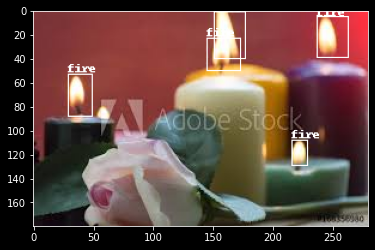

In [8]:
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))
print(class_id_to_name_mapping)

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("yolo-train-annotations", "Dataset/fire-dataset/train/images").replace("txt", "jpg")
print(image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [9]:
# Read images and annotations
train_images = [os.path.join('Dataset/fire-dataset/train/images', x) for x in os.listdir('Dataset/fire-dataset/train/images')]
train_annotations = [os.path.join('yolo-train-annotations', x) for x in os.listdir('yolo-train-annotations') if x[-3:] == "txt"]

train_images.sort()
train_annotations.sort()

In [10]:
val_annotations = [os.path.join('Dataset', 'fire-dataset', 'validation', 'annotations', x) for x in os.listdir('Dataset/fire-dataset/validation/annotations/') if x[-3:] == "xml"]
val_annotations.sort()

In [11]:
for ann in tqdm(val_annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict, training=False)

100%|██████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 1122.21it/s]


In [12]:
val_annotations = [os.path.join('yolo-val-annotations', x) for x in os.listdir('yolo-val-annotations') if x[-3:] == "txt"]

In [14]:
val_images = [os.path.join('Dataset/fire-dataset/validation/images', x) for x in os.listdir('Dataset/fire-dataset/validation/images')]
val_annotations = [os.path.join('yolo-val-annotations', x) for x in os.listdir('yolo-val-annotations') if x[-3:] == "txt"]

In [23]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')

In [30]:
import albumentations as A
import cv2

In [34]:
transform = A.Compose([A.Resize(200, 200, interpolation = cv2.INTER_NEAREST)], 
                     bbox_params=A.BboxParams(format='pascal_voc'))

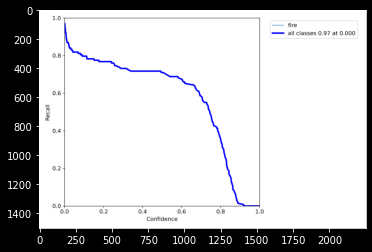

In [2]:
detections_dir = "yolov5/runs/train/fire/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))